In [1]:
%matplotlib inline
import emcee
import corner
import time
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
import scipy.integrate as integrate
import scipy.linalg as linalg
import IPython
from matplotlib.ticker import MaxNLocator
from multiprocessing.pool import ThreadPool
from getdist import plots, MCSamples, loadMCSamples, types
from scipy.special import gamma
from scipy.integrate import quad

global argsortz #array de indices de zsni ordenados

import os
os.environ["OMP_NUM_THREADS"] = "1"

np.random.seed(321)

### Data

In [3]:
#33 H(z) data
filename = 'data/Hz32Clocks.txt'
zhzi, hzi, shzi = np.genfromtxt(filename, comments='#', usecols=(0,1,2), unpack=True)

#Covariance data
filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

#number of data
ndata = len(zhzi)

### Some default configurations

In [4]:
pl.rcParams['text.usetex'] = True
pl.rcParams.update(pl.rcParamsDefault)
priorArray = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2]])
nstepHz = 5000

### Analysis functions

In [5]:
#Function to identify which model will be used
def free_par(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f = theta
            return [h0, wm, wl, f]
        elif flat == True:
            h0, wm, f = theta
            return [h0, wm, 1-wm, f]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl = theta
            return [h0, wm, wl, 1]
        elif flat == True:
            h0, wm = theta
            return [h0, wm, 1-wm, 1]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2Hz(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[0]*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHz(par):
    for i in range(len(par)):
        if not priorArray[i][0] < par[i] < priorArray[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHz(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])

def lnlikeHzA(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])


def lnprobHz(theta, freef, flat):
    par = free_par(theta, freef, flat)
    
    lp = lnpriorHz(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHz(par)

#Minimize chi2
def find_bestfit(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

#Run MC
def run_emcee(par_ml, nwalkers, lnprob, freef, flat, ainput, nsteps):
    ndim = len(par_ml)
    pos = [par_ml +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[freef, flat], a=ainput, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    accept = sampler.acceptance_fraction
    print('Acceptance fraction:',accept)
    print('Minimum acceptance:',np.amin(accept))
    print('Maximum acceptance:',np.amax(accept))
    
    return sampler

#Remove burn in
def tira_burnin(sampler, burnin, ndim):
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples


def burninthin(sampler, tau):
    taumax = np.amax(tau)
    taumin = np.amin(tau)
    samples = sampler.get_chain(discard=int(2*taumax), thin=int(taumin/2), flat=True)
    print(samples.shape)
    return samples

#MC results
def MC_result(samples, par_ml, parnames):
    ndim = len(par_ml)
    par_mean = np.mean(samples,axis=0)
    par_median = np.percentile(samples, [50], axis=0)[0]
    par_valm = np.percentile(samples, [15.865525393149998], axis=0)[0]
    par_valp = np.percentile(samples, [84.13447460685], axis=0)[0]
    par_valm2 = np.percentile(samples, [2.275013194800002], axis=0)[0]
    par_valp2 = np.percentile(samples, [97.7249868052], axis=0)[0]
    par_sigm = par_mean - par_valm
    par_sigp = par_valp - par_mean
    par_sigm2 = par_mean - par_valm2
    par_sigp2 = par_valp2 - par_mean
    print('MCMC result:')
    for i in range(ndim):
        print("""{0} = {1:5.5f} +{2:5.5f} +{3:5.5f} -{4:5.5f} -{5:5.5f} (median: {6:5.5f}, ml: {7:5.5f})"""\
              .format(parnames[i],par_mean[i],par_sigp[i],par_sigp2[i],par_sigm[i],par_sigm2[i],par_median[i],par_ml[i]))

#Insert a derived paramater
def insertDerived(sample, parnames, parlabel, num, gsample, derived, derivedName, derivedLabel):
    n = np.zeros(num)
    
    if derivedName not in parnames:
        newSample = np.c_[sample, derived]
        parnames.append(derivedName)
        gsample.addDerived(derived, name=derivedName, label=derivedLabel)
        
        return newSample, gsample, parnames, n

    elif derivedName in parnames:
        print('Parâmetro dependente já adicionado.')

        return sample, gsample, parnames, n

#Distribution funcion for chi2
def chiDist(chi, n):
    return (n**(n/2)*((chi)**((n-2)/2))*np.exp(-(n/2)*chi))/(2**(n/2)*gamma(n/2))

#Calculate cdf for chiDist
def chiCDF(x, n):
    res = np.zeros_like(x)
    for i, val in enumerate(x):
        y, err = quad(chiDist, 0, val, args=(n))
        res[i]=y
    return res

#Plot chi2 cdf
def plotChiDist(chimin, par, name=0):
    n = ndata - par
    chi = np.linspace(0, 2.5, 500)
    chiv = np.full((500), chimin/n)
    hv = chiDist(chi, n)
    cdf = chiCDF(chi, n)
    y = np.linspace(0, 1.8, 500)
    
    pl.plot(chi, hv, label=r"$h _{\nu}$")
    pl.plot(chiv, y, '--', label=r"$\chi _{\nu} ^{2}$" + "$= {0}$".format(np.round(chimin/n, 3)))
    pl.plot(chi, cdf, '--', label="cdf")
    
    pl.xticks(np.arange(0.0, 2.51, 0.5))
    pl.yticks(np.arange(0.0, 1.76, 0.25))
    pl.axis((0, 2.5, 0, 1.75))
    pl.grid(linestyle='-.', linewidth='0.5')
    pl.minorticks_on()
    
    pl.ylabel(r'$h_{\nu}$')
    pl.xlabel(r'$\chi _{\nu} ^{2}$')
    pl.legend(loc='best')
   
    if not name == 0:
        pl.savefig(name+'.pdf')
    
    pl.show()

## Computing the covariance matrix

In [6]:
cov_mat = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    cov_mat[i,i] = shzi[i]**2

inv_cov = linalg.inv(cov_mat)

In [7]:
cov_mat_diag = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    cov_mat_diag[i,i] = shzi[i]**2

imf_intp = np.interp(zhzi, zmod, imf)/100
spsooo_intp = np.interp(zhzi, zmod, spsooo)/100

cov_mat_imf = np.zeros((ndata, ndata), dtype='float64')
cov_mat_spsooo = np.zeros((ndata, ndata), dtype='float64')

for i in range(ndata):
    for j in range(ndata):
        cov_mat_imf[i,j] = hzi[i] * imf_intp[i] * hzi[j] * imf_intp[j]
        cov_mat_spsooo[i,j] = hzi[i] * spsooo_intp[i] * hzi[j] * spsooo_intp[j]

cov_mat = cov_mat_imf + cov_mat_spsooo + cov_mat_diag
inv_cov = linalg.inv(cov_mat)

# Uncorrected LCDM with curvature

In [8]:
par_HzC = [69.1929957609451,0.2480895086492853, 0.6862431649000225]
ndimC = len(par_HzC)
prefixC = 'LcdmHz32Cov'
parlabelsC = ["H_0","\\Omega_m", "\\Omega_\\Lambda"]
parlabtexC = ["$H_0$","$\\Omega_m$", "$\\Omega_\\Lambda$"]
parnamesC = ['H0','wm','wl']

resultHzC = find_bestfit(lnprobHz, par_HzC, parnamesC, freef=False, flat=False)
par_HzC = resultHzC['x']

Maximum likelihood result:
H0  =  68.23979301859242
wm  =  0.36817481934281626
wl  =  0.7664465117768737
chi2min = 14.492332505458794
Total time: 0.012 seg


In [9]:
samplerHzC = run_emcee(par_HzC, 100, lnprobHz, False, False, 2.0, nstepHz)

100%|██████████████████████████████████████| 5000/5000 [00:32<00:00, 156.08it/s]

Acceptance fraction: [0.634  0.6404 0.6224 0.6318 0.6318 0.6394 0.6326 0.634  0.6352 0.6318
 0.6314 0.6366 0.6344 0.627  0.6324 0.643  0.6408 0.6374 0.643  0.6328
 0.6332 0.6312 0.6272 0.636  0.6392 0.6412 0.6348 0.634  0.635  0.6366
 0.6298 0.628  0.636  0.64   0.635  0.622  0.6386 0.642  0.6262 0.6278
 0.6172 0.6342 0.6278 0.6454 0.6302 0.644  0.634  0.6426 0.649  0.6294
 0.6248 0.6346 0.6404 0.6234 0.633  0.6368 0.6468 0.6204 0.6378 0.6382
 0.628  0.6282 0.6508 0.623  0.6348 0.6308 0.6326 0.6316 0.6322 0.64
 0.6322 0.6338 0.6316 0.625  0.6432 0.6352 0.634  0.6274 0.636  0.6442
 0.6276 0.6274 0.6398 0.6334 0.6368 0.631  0.6352 0.619  0.637  0.6364
 0.64   0.6228 0.6376 0.6364 0.6402 0.6218 0.631  0.6248 0.6398 0.628 ]
Minimum acceptance: 0.6172
Maximum acceptance: 0.6508


In [10]:
tauHzC = samplerHzC.get_autocorr_time()
print(tauHzC)

tauHzmaxC = np.amax(tauHzC)
r = nstepHz/tauHzmaxC
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[41.75590103 41.56631131 39.21509052]
119.74355424799195
Convergiu! :)


In [11]:
samplesHzC = burninthin(samplerHzC, 100)

(9600, 3)


In [12]:
MC_result(samplesHzC, par_HzC, parnamesC)

MCMC result:
H0 = 66.47570 +6.40090 +12.37002 -6.38937 -12.40489 (median: 66.51997, ml: 68.23979)
wm = 0.37301 +0.20021 +0.41471 -0.20974 -0.34514 (median: 0.36669, ml: 0.36817)
wl = 0.68731 +0.41135 +0.75724 -0.41672 -0.84195 (median: 0.69903, ml: 0.76645)


In [13]:
gsamplesHzC = MCSamples(samples=samplesHzC, names=parnamesC, labels=parlabelsC, ranges={'wm':(0, None)})
gsamplesHzC.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


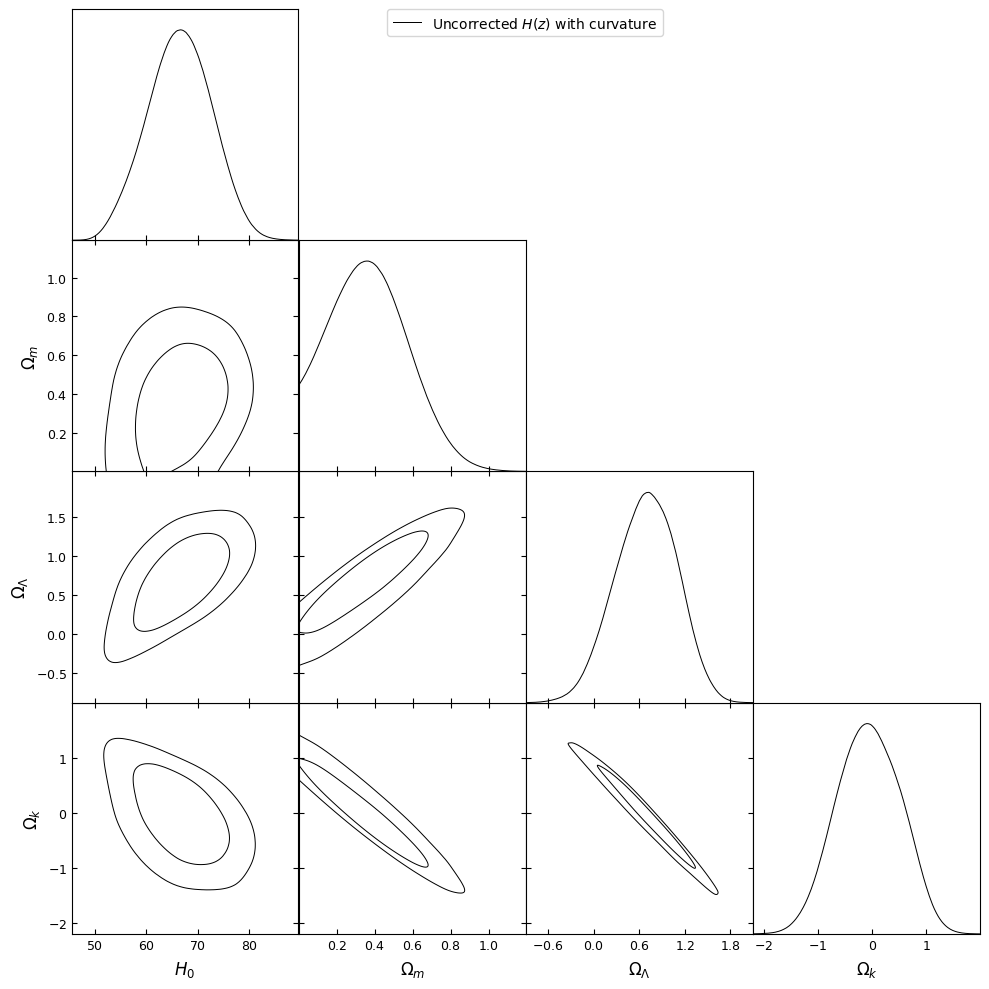

In [64]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
pl.show()
#g.export('fig/g'+prefixC+'All-triangle.pdf')

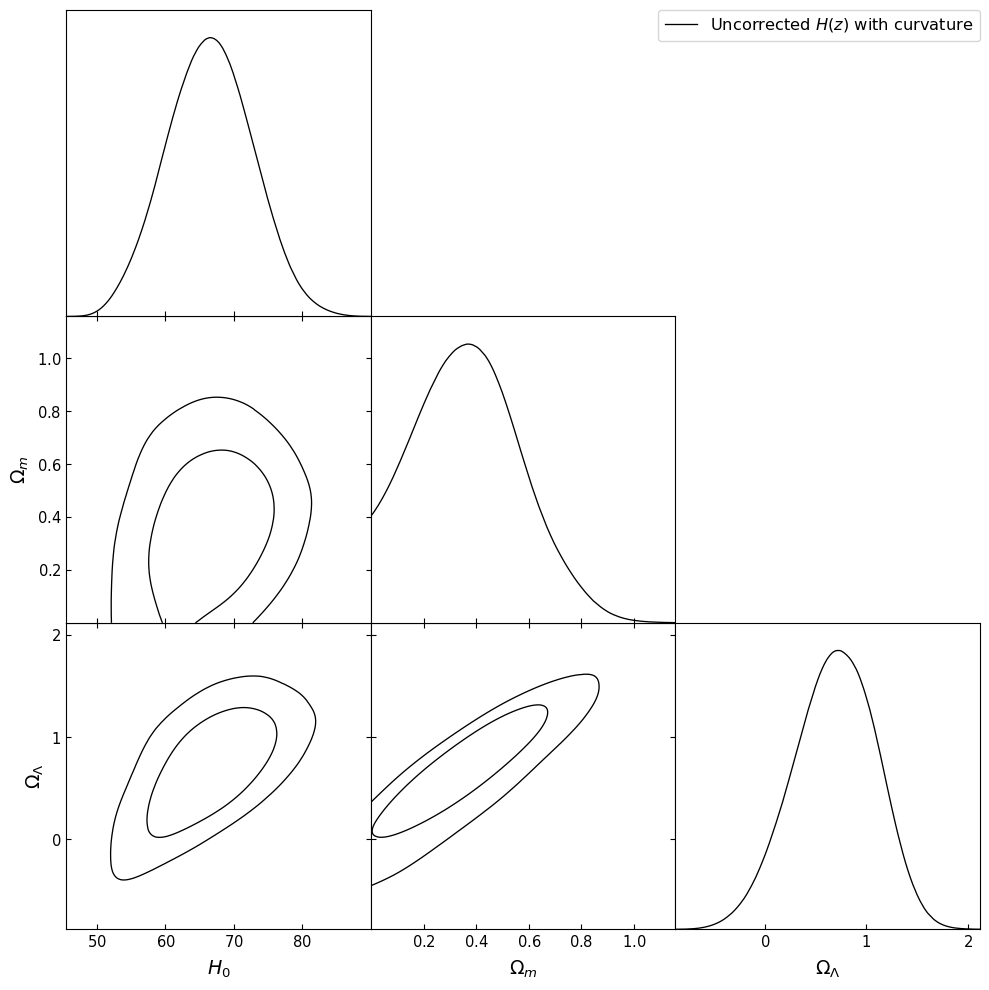

In [15]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
pl.show()
g.export('figNEW/g'+prefixC+'All_triangle_No_Ok.pdf')

In [16]:
samplesHzC, gsamplesHzC, parnamesC, ndim = insertDerived(samplesHzC, parnamesC, parlabelsC, 4, gsamplesHzC, 1 - gsamplesHzC.getParams().wm - gsamplesHzC.getParams().wl, 'wk', '\\Omega_k')

In [17]:
MC_result(samplesHzC, ndim, parnamesC)

MCMC result:
H0 = 66.47570 +6.40090 +12.37002 -6.38937 -12.40489 (median: 66.51997, ml: 0.00000)
wm = 0.37301 +0.20021 +0.41471 -0.20974 -0.34514 (median: 0.36669, ml: 0.00000)
wl = 0.68731 +0.41135 +0.75724 -0.41672 -0.84195 (median: 0.69903, ml: 0.00000)
wk = -0.06032 +0.61129 +1.12566 -0.59300 -1.14087 (median: -0.06532, ml: 0.00000)


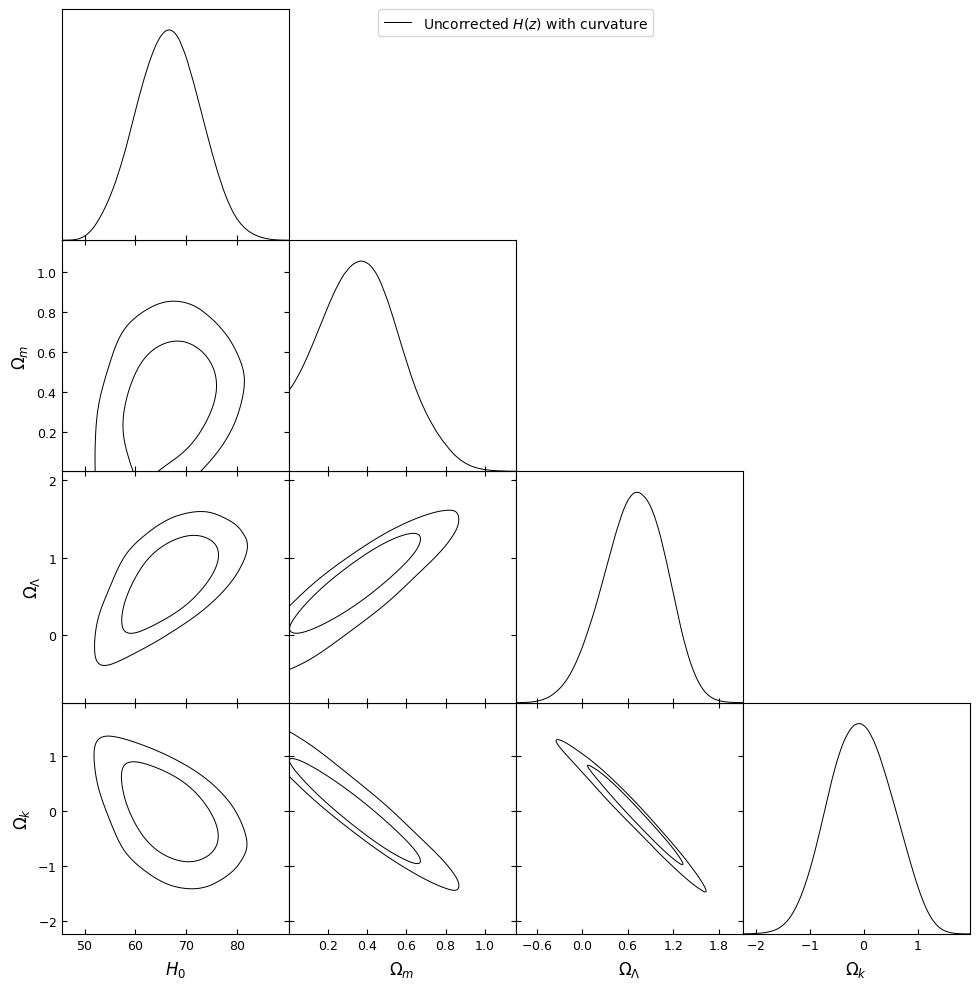

In [18]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzC], filled=False, legend_labels=['Uncorrected $H(z)$ with curvature'])
pl.show()
g.export('fig/g'+prefixC+'All_triangle.pdf')

In [19]:
for i in range(len(ndim)):
    for j in range(1,4):
        print(gsamplesHzC.getInlineLatex(parnamesC[i],limit=j))
        
print(gsamplesHzC.getTable().tableTex())

H_0 = 66.5\pm 6.3
H_0 = 66^{+10}_{-10}
H_0 = 66^{+20}_{-20}
\Omega_m = 0.37^{+0.18}_{-0.23}
\Omega_m < 0.719
\Omega_m < 0.848
\Omega_\Lambda = 0.69^{+0.44}_{-0.37}
\Omega_\Lambda = 0.69^{+0.75}_{-0.83}
\Omega_\Lambda = 0.69^{+0.94}_{-1.1}
\Omega_k = -0.06\pm 0.58
\Omega_k = -0.1^{+1.1}_{-1.1}
\Omega_k = -0.1^{+1.4}_{-1.4}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $66^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.719                   $\\

{\boldmath$\Omega_\Lambda $} & $0.69^{+0.75}_{-0.83}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


In [30]:
print(types.ResultTable(ncol=1,results=gsamplesHzC, paramList=parnamesC, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $66^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $< 0.723                   $\\

{\boldmath$\Omega_\Lambda $} & $0.69^{+0.75}_{-0.81}      $\\

$\Omega_k                  $ & $-0.1^{+1.1}_{-1.1}        $\\
\hline
\end{tabular}


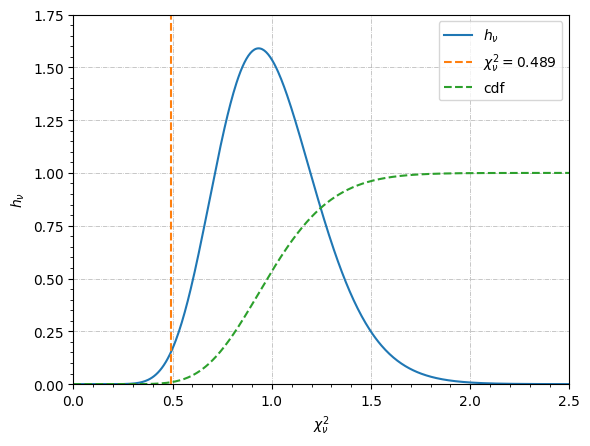

Probabilidade =  0.8585236604846332
Chiv =  0.4894144079073363


In [20]:
chi2mC = chi2Hz(free_par([66.60620, 0.37645, 0.69908], freef=False, flat=False))
chivCperc, errF = quad(chiDist, 0, chi2mC/(ndata-len(par_HzC)), args=(ndata-len(par_HzC)))
plotChiDist(chi2mC, len(par_HzC))
print('Probabilidade = ', chivCperc*100)
print('Chiv = ', chi2mC/(ndata-len(par_HzC)))

# Corrected LCDM with curvature

In [21]:
par_HzCF = [69.1929957609451,0.2480895086492853, 0.6862431649000225, .9]
ndimCF = len(par_HzCF)
prefixCF = 'LcdmHz32Cov'
parlabelsCF = ["H_0","\\Omega_m", "\\Omega_\\Lambda", "f"]
parlabtexCF = ["$H_0$","$\\Omega_m$", "$\\Omega_\\Lambda$", "$f$"]
parnamesCF = ['H0','wm','wl', 'f']

resultHzCF = find_bestfit(lnprobHz, par_HzCF, parnamesCF, freef=True, flat=False)
par_HzCF = resultHzCF['x']

Maximum likelihood result:
H0  =  68.23980397883055
wm  =  0.36817497272002186
wl  =  0.7664470549779099
f  =  0.6626926832046859
chi2min = 5.844701127309911
Total time: 0.019 seg


In [22]:
samplerHzCF = run_emcee(par_HzCF, 100, lnprobHz, True, False, 2.0, nstepHz)

100%|██████████████████████████████████████| 5000/5000 [00:34<00:00, 146.86it/s]

Acceptance fraction: [0.581  0.5872 0.5696 0.5924 0.589  0.571  0.58   0.584  0.593  0.5978
 0.5774 0.5866 0.5806 0.597  0.5858 0.5968 0.5874 0.5878 0.5868 0.5908
 0.5838 0.5782 0.583  0.5944 0.5882 0.5796 0.5828 0.5844 0.5832 0.5954
 0.5926 0.5822 0.5826 0.5956 0.5892 0.5798 0.5888 0.6014 0.5758 0.5854
 0.5888 0.5804 0.5836 0.5826 0.5898 0.6024 0.5888 0.594  0.6006 0.589
 0.587  0.574  0.598  0.5818 0.5904 0.5886 0.587  0.5768 0.5702 0.581
 0.582  0.5756 0.5958 0.605  0.5862 0.5846 0.5834 0.5888 0.5792 0.5892
 0.5822 0.5754 0.5792 0.5768 0.5988 0.5798 0.587  0.5826 0.5776 0.5874
 0.5826 0.5936 0.5848 0.5848 0.5854 0.5906 0.5778 0.5898 0.5692 0.569
 0.5838 0.5828 0.585  0.5974 0.6008 0.589  0.5912 0.586  0.5824 0.5834]
Minimum acceptance: 0.569
Maximum acceptance: 0.605


In [23]:
tauHzCF = samplerHzCF.get_autocorr_time()
print(tauHzCF)

tauHzmaxCF = np.amax(tauHzCF)
r = nstepHz/tauHzmaxCF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[48.81826697 47.60632979 50.09254972 43.32005101]
99.81524253698336
Convergiu! :)


In [24]:
samplesHzCF = burninthin(samplerHzCF, 100)

(9600, 4)


In [25]:
MC_result(samplesHzCF, par_HzCF, parnamesCF)

MCMC result:
H0 = 67.03181 +4.64412 +9.34944 -4.64530 -9.80464 (median: 67.07226, ml: 68.23980)
wm = 0.35683 +0.15734 +0.32005 -0.16266 -0.30739 (median: 0.35781, ml: 0.36817)
wl = 0.69512 +0.31981 +0.58648 -0.32943 -0.67407 (median: 0.71535, ml: 0.76645)
f = 0.72474 +0.09620 +0.22767 -0.09639 -0.16637 (median: 0.71398, ml: 0.66269)


In [26]:
gsamplesHzCF = MCSamples(samples=samplesHzCF, names=parnamesCF, labels=parlabelsCF, ranges={'wm':(0, None)})
gsamplesHzCF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


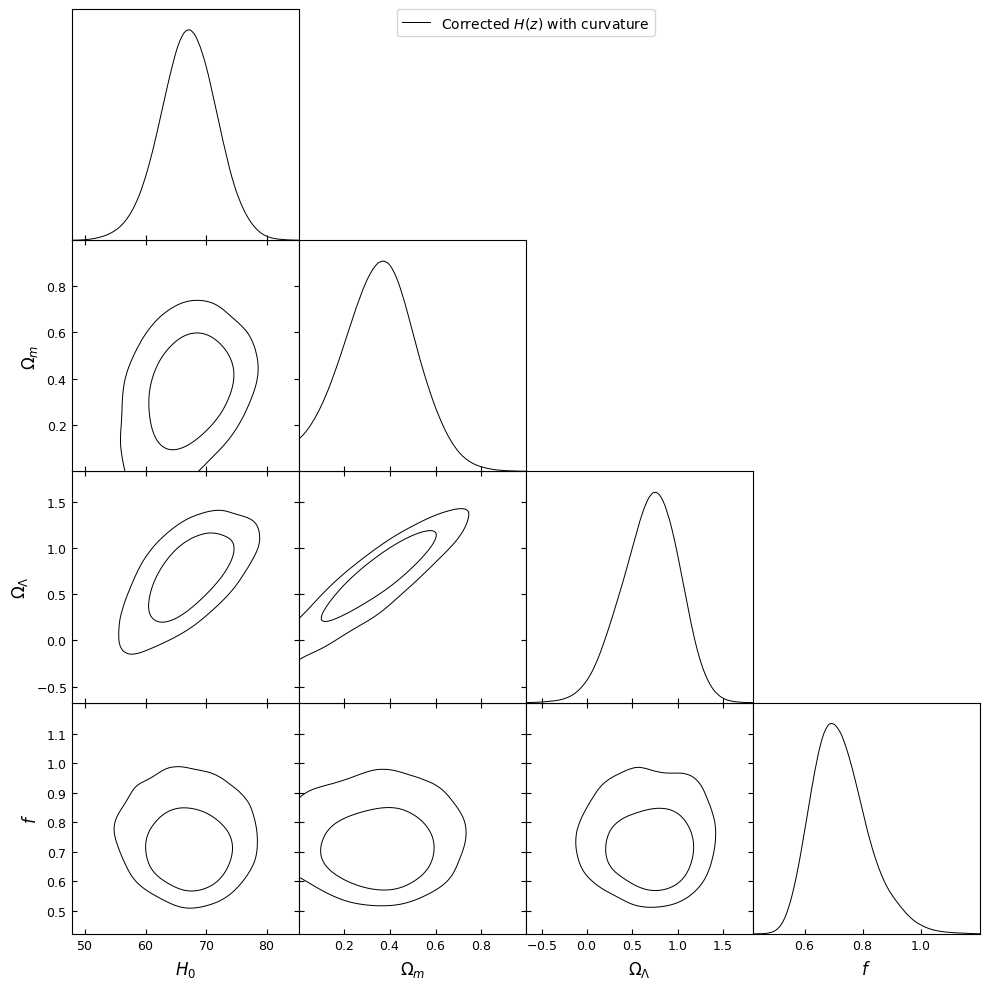

In [27]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCF], filled=False, legend_labels=['Corrected $H(z)$ with curvature'])
pl.show()
g.export('fig/g'+prefixCF+'All_triangle_No_Ok.pdf')

In [28]:
samplesHzCF1, gsamplesHzCF1, parnamesCF1, ndimCF1 = insertDerived(samplesHzCF, parnamesCF, parlabelsCF, 5, gsamplesHzCF, 1 - gsamplesHzCF.getParams().wm - gsamplesHzCF.getParams().wl, 'wk', '\\Omega_k')

In [29]:
MC_result(samplesHzCF1, ndimCF1, parnamesCF1)

MCMC result:
H0 = 67.03181 +4.64412 +9.34944 -4.64530 -9.80464 (median: 67.07226, ml: 0.00000)
wm = 0.35683 +0.15734 +0.32005 -0.16266 -0.30739 (median: 0.35781, ml: 0.00000)
wl = 0.69512 +0.31981 +0.58648 -0.32943 -0.67407 (median: 0.71535, ml: 0.00000)
f = 0.72474 +0.09620 +0.22767 -0.09639 -0.16637 (median: 0.71398, ml: 0.00000)
wk = -0.05195 +0.47460 +0.94996 -0.45902 -0.89081 (median: -0.06998, ml: 0.00000)


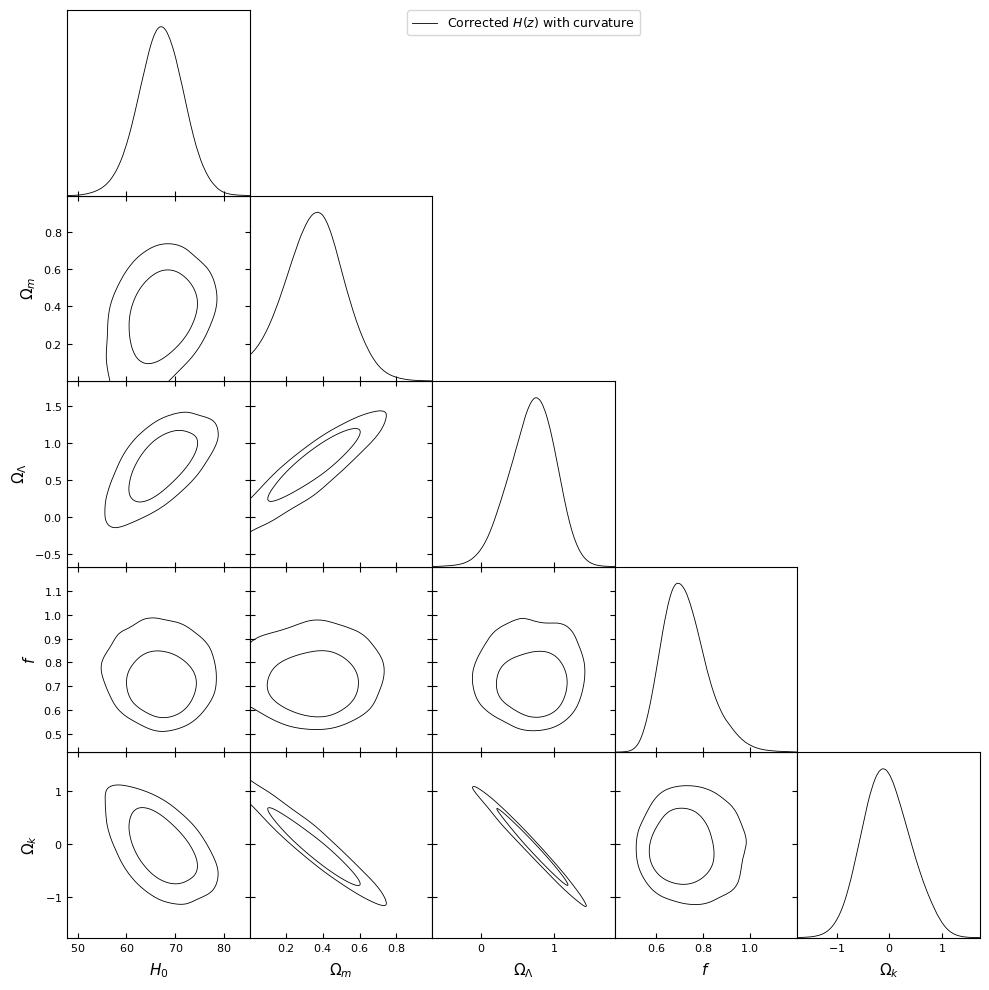

In [30]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzCF1], filled=False, legend_labels=['Corrected $H(z)$ with curvature'])
pl.show()
g.export('fig/g'+prefixCF+'All_triangle_Ok.pdf')

In [31]:
for i in range(len(ndim)):
    for j in range(1,4):
        print(gsamplesHzCF.getInlineLatex(parnamesCF[i],limit=j))
        
print(gsamplesHzCF.getTable().tableTex())

H_0 = 67.0\pm 4.7
H_0 = 67^{+9}_{-10}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.36\pm 0.16
\Omega_m = 0.36^{+0.29}_{-0.32}
\Omega_m < 0.732
\Omega_\Lambda = 0.70^{+0.35}_{-0.28}
\Omega_\Lambda = 0.70^{+0.57}_{-0.66}
\Omega_\Lambda = 0.70^{+0.73}_{-0.88}
f = 0.725^{+0.074}_{-0.11}
f = 0.72^{+0.20}_{-0.18}
f = 0.72^{+0.31}_{-0.20}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+9}_{-10}             $\\

{\boldmath$\Omega_m       $} & $0.36^{+0.29}_{-0.32}      $\\

{\boldmath$\Omega_\Lambda $} & $0.70^{+0.57}_{-0.66}      $\\

{\boldmath$f              $} & $0.72^{+0.20}_{-0.18}      $\\

$\Omega_k                  $ & $-0.05^{+0.93}_{-0.87}     $\\
\hline
\end{tabular}


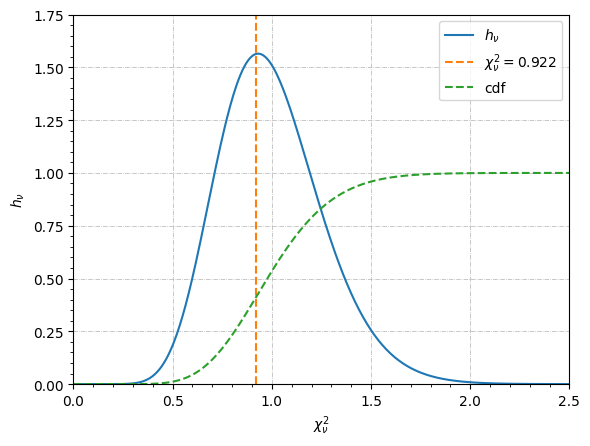

Probabilidade =  41.47591390159699
Chiv =  0.9223820828634633


In [32]:
chi2CF=chi2Hz(free_par([67.16828,0.36434,0.71192,0.73771], freef=True, flat=False))
plotChiDist(chi2CF, len(par_HzCF), name='chi2OLCDM')
chivCFperc, errF = quad(chiDist, 0, chi2CF/(ndata-len(par_HzCF)), args=(ndata-len(par_HzCF)))
print('Probabilidade = ', chivCFperc*100)
print('Chiv = ', chi2CF/(ndata-len(par_HzCF)))

# Comparison between corrected and uncorrected H(z) with curvature

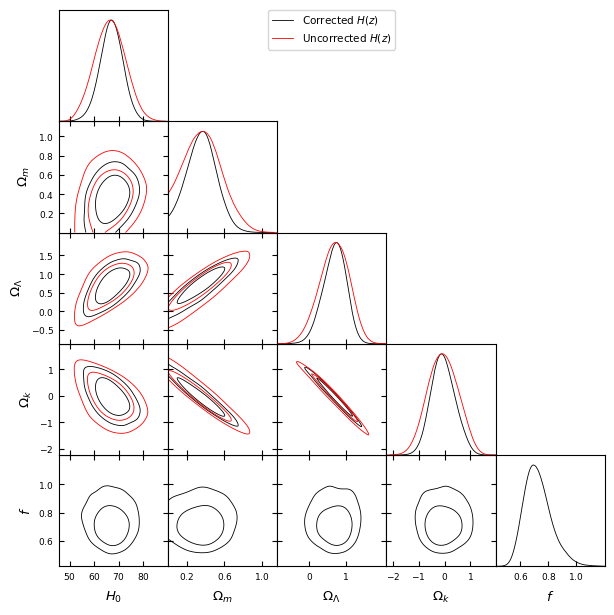

In [33]:
g = plots.getSubplotPlotter(subplot_size=1.25)
g.triangle_plot([gsamplesHzCF1, gsamplesHzC], [parnamesCF[0],parnamesCF[1],parnamesCF[2],parnamesCF[4],parnamesCF[3]],filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
g.export('fig/gcomp_UncCorr_All_triangle.pdf')
pl.show()

# Uncorrected Flat LCDM

In [34]:
par_HzF = [69.1929957609451, 0.2480895086492853]
ndimF = len(par_HzF)
prefixF = 'FlatLcdmHz32Cov'
parlabelsF = ["H_0","\\Omega_m"]
parlabtexF = ["$H_0$","$\\Omega_m$"]
parnamesF = ['H0','wm']

resultHzF = find_bestfit(lnprobHz, par_HzF, parnamesF, freef=False, flat=True)
par_mlHzF = resultHzF['x']

Maximum likelihood result:
H0  =  67.53068559463878
wm  =  0.32398576775413607
chi2min = 14.533396574606256
Total time: 0.009 seg


In [35]:
samplerHzF = run_emcee(par_HzF, 100, lnprobHz, False, True, 2.0, nstepHz)

100%|██████████████████████████████████████| 5000/5000 [00:32<00:00, 152.05it/s]

Acceptance fraction: [0.7102 0.7212 0.7014 0.7204 0.714  0.7144 0.7038 0.7178 0.7236 0.7136
 0.708  0.715  0.7044 0.709  0.7116 0.7288 0.7234 0.6998 0.7214 0.7122
 0.7186 0.7176 0.707  0.7134 0.725  0.7288 0.702  0.717  0.7198 0.716
 0.708  0.7146 0.7152 0.7214 0.7118 0.7004 0.721  0.7234 0.7112 0.7064
 0.7032 0.7196 0.7168 0.717  0.7148 0.7274 0.7046 0.7126 0.7208 0.7148
 0.712  0.72   0.7134 0.7148 0.7052 0.7082 0.7242 0.7156 0.7028 0.719
 0.708  0.7004 0.7318 0.7082 0.7274 0.7152 0.7038 0.703  0.7114 0.7176
 0.718  0.7146 0.7102 0.715  0.721  0.716  0.7184 0.705  0.7054 0.7168
 0.7014 0.7166 0.7184 0.7136 0.7102 0.7166 0.712  0.7016 0.7084 0.71
 0.7204 0.7062 0.7108 0.7164 0.71   0.7108 0.7164 0.712  0.725  0.709 ]
Minimum acceptance: 0.6998
Maximum acceptance: 0.7318


In [36]:
tauHzF = samplerHzF.get_autocorr_time()
print(tauHzF)

tauHzmaxF = np.amax(tauHzF)
r = nstepHz/tauHzmaxF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[30.54991338 30.83708083]
162.14245532054812
Convergiu! :)


In [37]:
samplesHzF = burninthin(samplerHzF, tauHzF)

(32900, 2)


In [38]:
MC_result(samplesHzF, par_HzF, parnamesF)

MCMC result:
H0 = 66.65040 +5.39637 +10.75589 -5.42026 -10.83690 (median: 66.65412, ml: 69.19300)
wm = 0.34282 +0.07025 +0.17124 -0.07053 -0.12100 (median: 0.33488, ml: 0.24809)


In [39]:
gsamplesHzF = MCSamples(samples=samplesHzF, names=parnamesF, labels=parlabelsF, ranges={'wm':(0, None)})
gsamplesHzF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


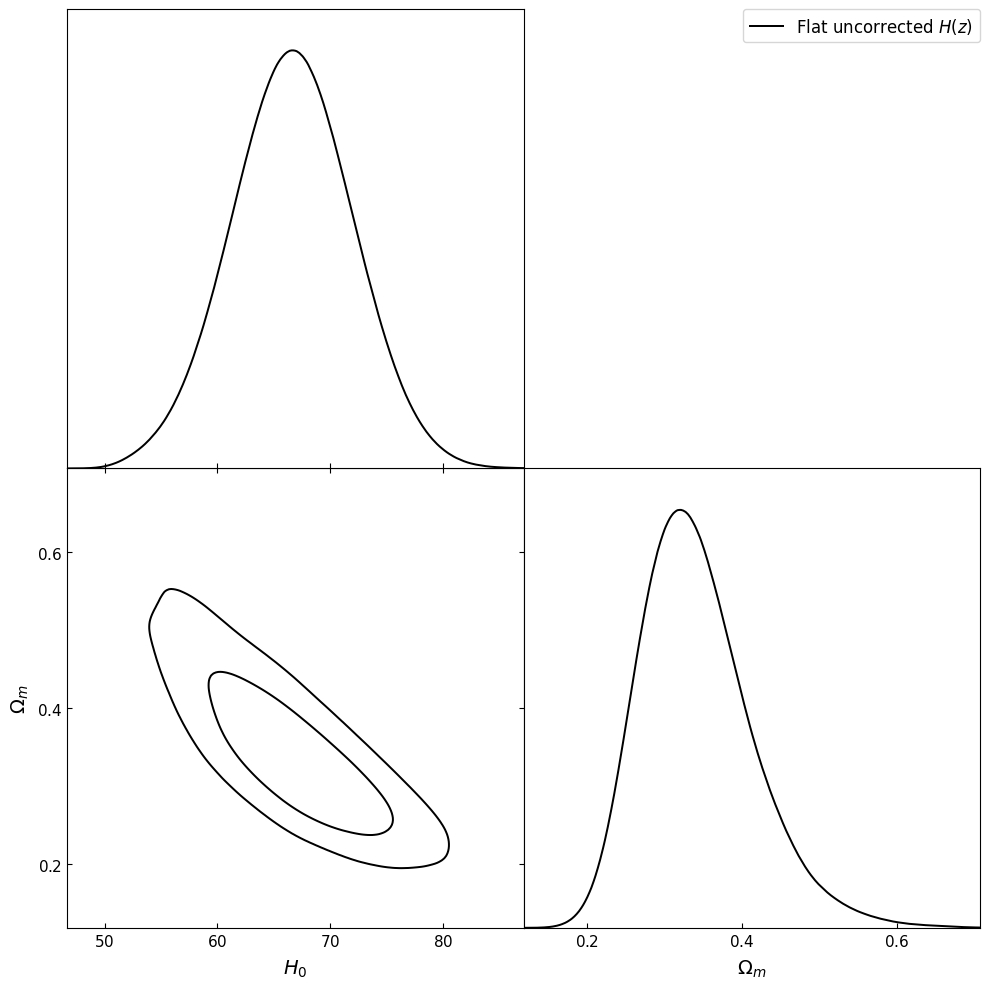

In [40]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
pl.show()
g.export('fig/g'+prefixF+'All_triangle_No_Ol.pdf')

In [41]:
samplesHzF, gsamplesHzF, parnamesF, ndim = insertDerived(samplesHzF, parnamesF, parlabelsF, 3, gsamplesHzF, 1 - gsamplesHzF.getParams().wm, 'wl', '\\Omega _{\\Lambda}')

In [42]:
MC_result(samplesHzF, ndim, parnamesF)

MCMC result:
H0 = 66.65040 +5.39637 +10.75589 -5.42026 -10.83690 (median: 66.65412, ml: 0.00000)
wm = 0.34282 +0.07025 +0.17124 -0.07053 -0.12100 (median: 0.33488, ml: 0.00000)
wl = 0.65718 +0.07053 +0.12100 -0.07025 -0.17124 (median: 0.66512, ml: 0.00000)


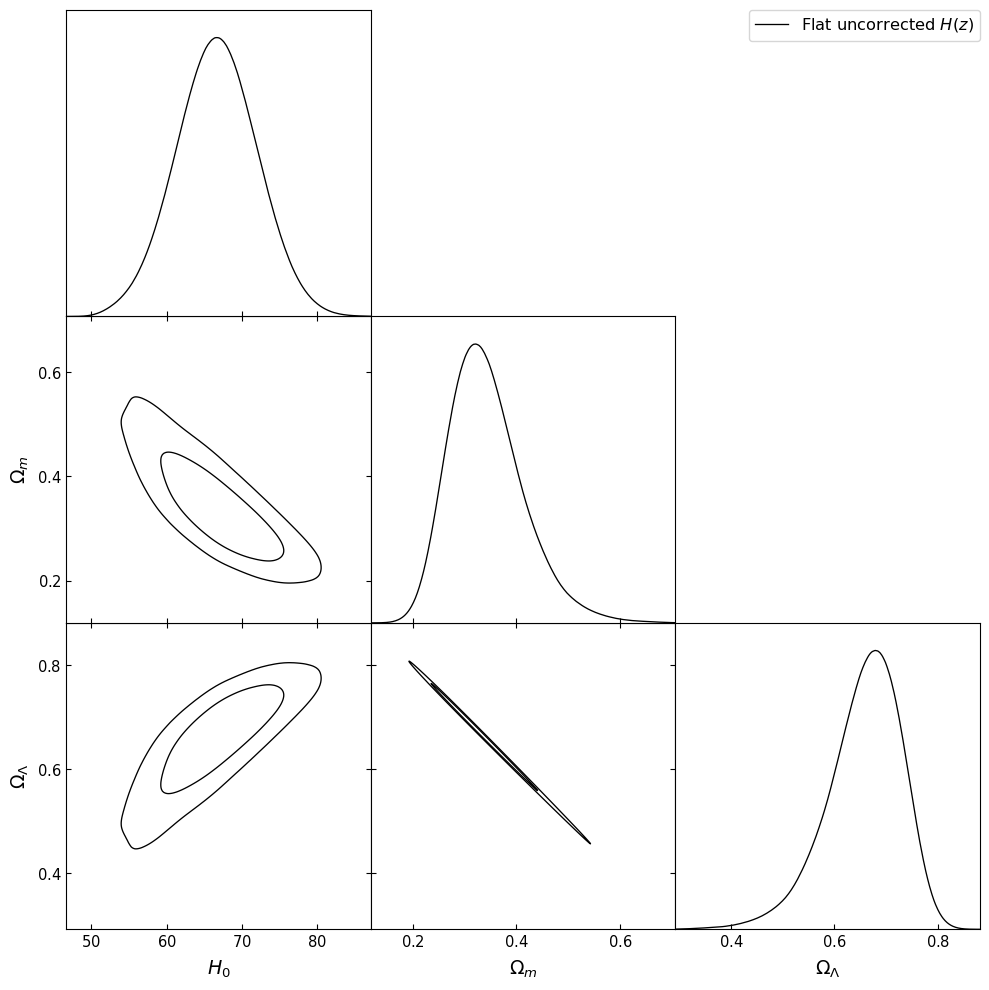

In [43]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
pl.show()
g.export('fig/g'+prefixF+'All_triangle_Ol.pdf')

In [60]:
for i in range(ndimF+1):
    for j in range(1,4):
        print(gsamplesHzF.getInlineLatex(parnamesF[i],limit=j))
        
print(gsamplesHzF.getTable().tableTex())

H_0 = 66.7\pm 5.5
H_0 = 67^{+10}_{-10}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.342^{+0.054}_{-0.084}
\Omega_m = 0.34^{+0.15}_{-0.13}
\Omega_m = 0.34^{+0.24}_{-0.15}
\Omega _{\Lambda} = 0.658^{+0.084}_{-0.054}
\Omega _{\Lambda} = 0.66^{+0.13}_{-0.15}
\Omega _{\Lambda} = 0.66^{+0.15}_{-0.24}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $0.34^{+0.15}_{-0.13}      $\\

$\Omega _{\Lambda}         $ & $0.66^{+0.13}_{-0.15}      $\\
\hline
\end{tabular}


In [61]:
print(types.ResultTable(ncol=1,results=gsamplesHzF, paramList=parnamesF, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+10}_{-10}            $\\

{\boldmath$\Omega_m       $} & $0.34^{+0.15}_{-0.13}      $\\

$\Omega _{\Lambda}         $ & $0.66^{+0.13}_{-0.15}      $\\
\hline
\end{tabular}


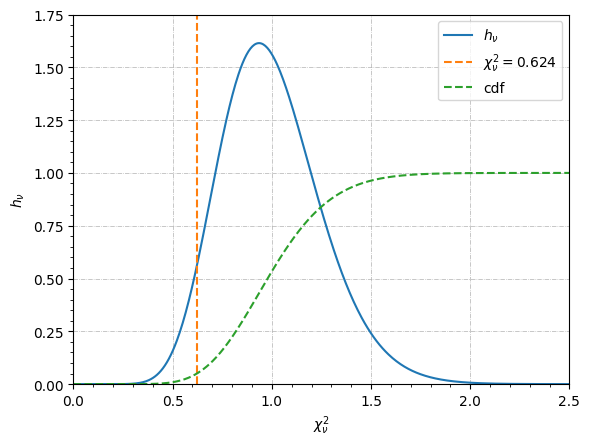

Probabilidade =  5.107271401499033
Chiv =  0.623855718198682


In [44]:
chi2F=chi2Hz(free_par([56.84412,0.40977], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF))
chivFperc, errF = quad(chiDist, 0, chi2F/(ndata-len(par_HzF)), args=(ndata-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(ndata-len(par_HzF)))

# Corrected Flat LCDM

In [45]:
par_HzFf = [69.1929957609451,0.2480895086492853, .9]
ndimFf = len(par_HzFf)
prefixFf = 'LcdmHz32CovCorr'
parlabelsFf = ['H_0','\\Omega_m', 'f']
parlabtexFf = ['$H_0$','$\\Omega_m$', '$f$']
parnamesFf = ['H0','wm', 'f']

resultHzFf = find_bestfit(lnprobHz, par_HzFf, parnamesFf, freef=True, flat=True)
par_mlHzFf = resultHzFf['x']

Maximum likelihood result:
H0  =  67.53068654286956
wm  =  0.32398575333978213
f  =  0.6636308780529803
chi2min = 5.938074505264275
Total time: 0.007 seg


In [46]:
samplerHzFf = run_emcee(par_HzFf, 100, lnprobHz, True, True, 2.0, 20000)

100%|████████████████████████████████████| 20000/20000 [02:05<00:00, 159.17it/s]

Acceptance fraction: [0.64365 0.64955 0.63575 0.63735 0.6404  0.64605 0.63645 0.64115 0.64065
 0.64245 0.63635 0.643   0.63975 0.6412  0.64725 0.6417  0.64325 0.63925
 0.6413  0.6433  0.6505  0.6458  0.63905 0.6386  0.637   0.64065 0.6393
 0.6445  0.63675 0.6443  0.6427  0.6446  0.64655 0.6441  0.6423  0.6404
 0.6413  0.6429  0.64445 0.641   0.62875 0.63495 0.64655 0.6474  0.6387
 0.64435 0.64135 0.6364  0.6483  0.6491  0.6455  0.6408  0.64105 0.63735
 0.63695 0.6386  0.6431  0.6335  0.6394  0.6449  0.64175 0.6359  0.6424
 0.63875 0.64045 0.6456  0.6449  0.64015 0.6397  0.6441  0.63565 0.63495
 0.6392  0.6367  0.64425 0.64585 0.6431  0.6388  0.647   0.63965 0.6431
 0.64085 0.6361  0.64605 0.6437  0.64355 0.63895 0.63545 0.6351  0.64615
 0.64175 0.63935 0.644   0.64435 0.637   0.64525 0.6447  0.6345  0.64205
 0.64105]
Minimum acceptance: 0.62875
Maximum acceptance: 0.6505


In [47]:
tauHzFf = samplerHzFf.get_autocorr_time()
print(tauHzFf)

tauHzmaxFf = np.amax(tauHzFf)
r = nstepHz/tauHzmaxFf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[40.35887907 40.87026666 40.85250841]
122.33832582996587
Convergiu! :)


In [48]:
samplesHzFf = burninthin(samplerHzFf, tauHzFf)

(99500, 3)


In [49]:
MC_result(samplesHzFf, par_mlHzFf, parnamesFf)

MCMC result:
H0 = 67.07725 +3.83413 +7.81439 -3.85298 -8.01646 (median: 67.12832, ml: 67.53069)
wm = 0.33362 +0.04851 +0.11513 -0.04883 -0.08863 (median: 0.32926, ml: 0.32399)
f = 0.71485 +0.09315 +0.22170 -0.09275 -0.16037 (median: 0.70460, ml: 0.66363)


In [50]:
gsamplesHzFf = MCSamples(samples=samplesHzFf, names=parnamesFf, labels=parlabelsFf, ranges={'wm':(0, None)})
gsamplesHzFf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


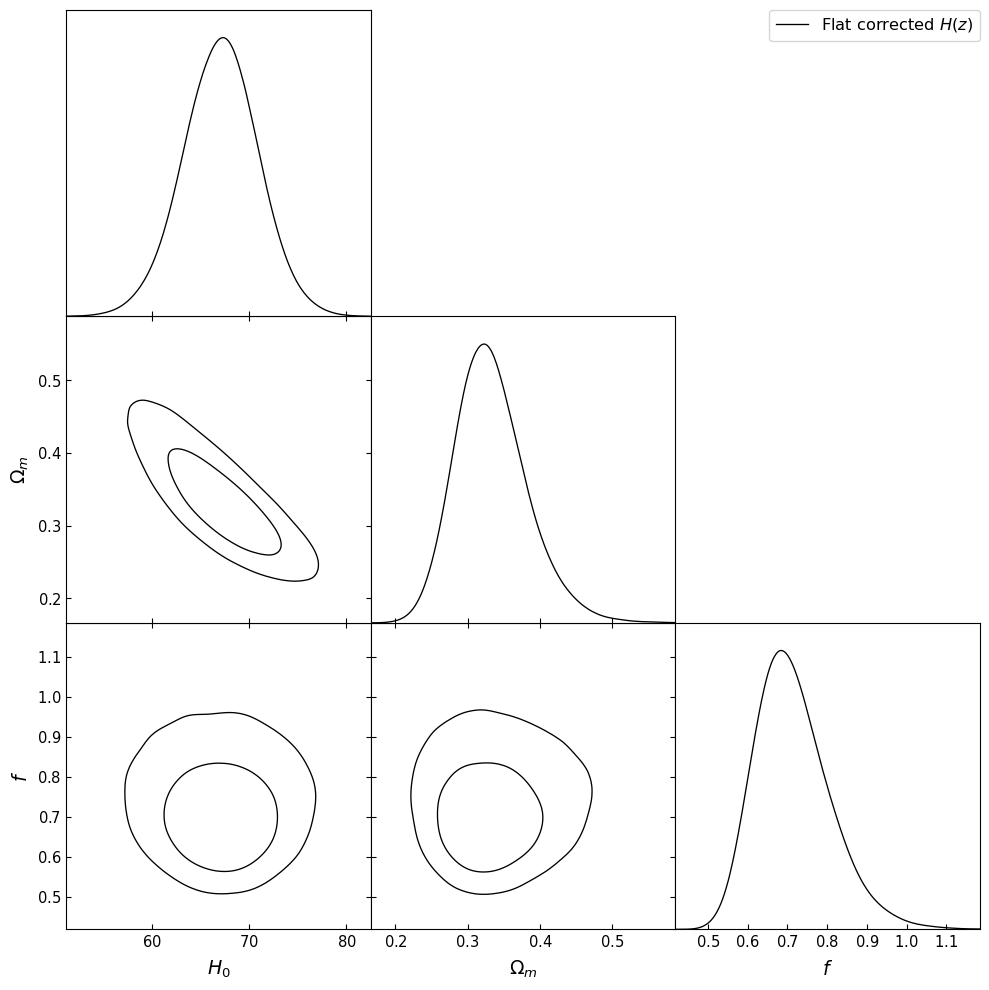

In [51]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf], filled=False, legend_labels=['Flat corrected $H(z)$'])
pl.show()
g.export('fig/g'+prefixFf+'All_triangle_No_Ol.pdf')

In [52]:
samplesHzFf, gsamplesHzFf, parnamesFf, ndim = insertDerived(samplesHzFf, parnamesFf, parlabelsFf, 4, gsamplesHzFf, 1 - gsamplesHzFf.getParams().wm, 'wl', '\\Omega _{\\Lambda}')

In [53]:
MC_result(samplesHzFf, ndim, parnamesFf)

MCMC result:
H0 = 67.07725 +3.83413 +7.81439 -3.85298 -8.01646 (median: 67.12832, ml: 0.00000)
wm = 0.33362 +0.04851 +0.11513 -0.04883 -0.08863 (median: 0.32926, ml: 0.00000)
f = 0.71485 +0.09315 +0.22170 -0.09275 -0.16037 (median: 0.70460, ml: 0.00000)
wl = 0.66638 +0.04883 +0.08863 -0.04851 -0.11513 (median: 0.67074, ml: 0.00000)


In [54]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf], filled=False, legend_labels=['Flat corrected $H(z)$'])
pl.show
g.export('fig/g'+prefixFf+'All_triangle_Ol.pdf')

In [20]:
for i in range(ndimFf+1):
    for j in range(1,4):
        print(gsamplesHzFf.getInlineLatex(parnamesFf[i],limit=j))
        
print(gsamplesHzFf.getTable().tableTex())

H_0 = 67.1\pm 4.0
H_0 = 67^{+8}_{-8}
H_0 = 67^{+10}_{-10}
\Omega_m = 0.333^{+0.040}_{-0.057}
\Omega_m = 0.333^{+0.11}_{-0.096}
\Omega_m = 0.33^{+0.17}_{-0.11}
f = 0.727^{+0.072}_{-0.11}
f = 0.73^{+0.20}_{-0.18}
f = 0.73^{+0.32}_{-0.20}
\Omega _{\Lambda} = 0.667^{+0.057}_{-0.040}
\Omega _{\Lambda} = 0.667^{+0.096}_{-0.11}
\Omega _{\Lambda} = 0.67^{+0.11}_{-0.17}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+8}_{-8}              $\\

{\boldmath$\Omega_m       $} & $0.333^{+0.11}_{-0.096}    $\\

{\boldmath$f              $} & $0.73^{+0.20}_{-0.18}      $\\

$\Omega _{\Lambda}         $ & $0.667^{+0.096}_{-0.11}    $\\
\hline
\end{tabular}


In [21]:
print(types.ResultTable(ncol=1,results=gsamplesHzFf, paramList=parnamesFf, limit=2).tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $67^{+8}_{-8}              $\\

{\boldmath$\Omega_m       $} & $0.333^{+0.11}_{-0.096}    $\\

{\boldmath$f              $} & $0.73^{+0.20}_{-0.18}      $\\

$\Omega _{\Lambda}         $ & $0.667^{+0.096}_{-0.11}    $\\
\hline
\end{tabular}


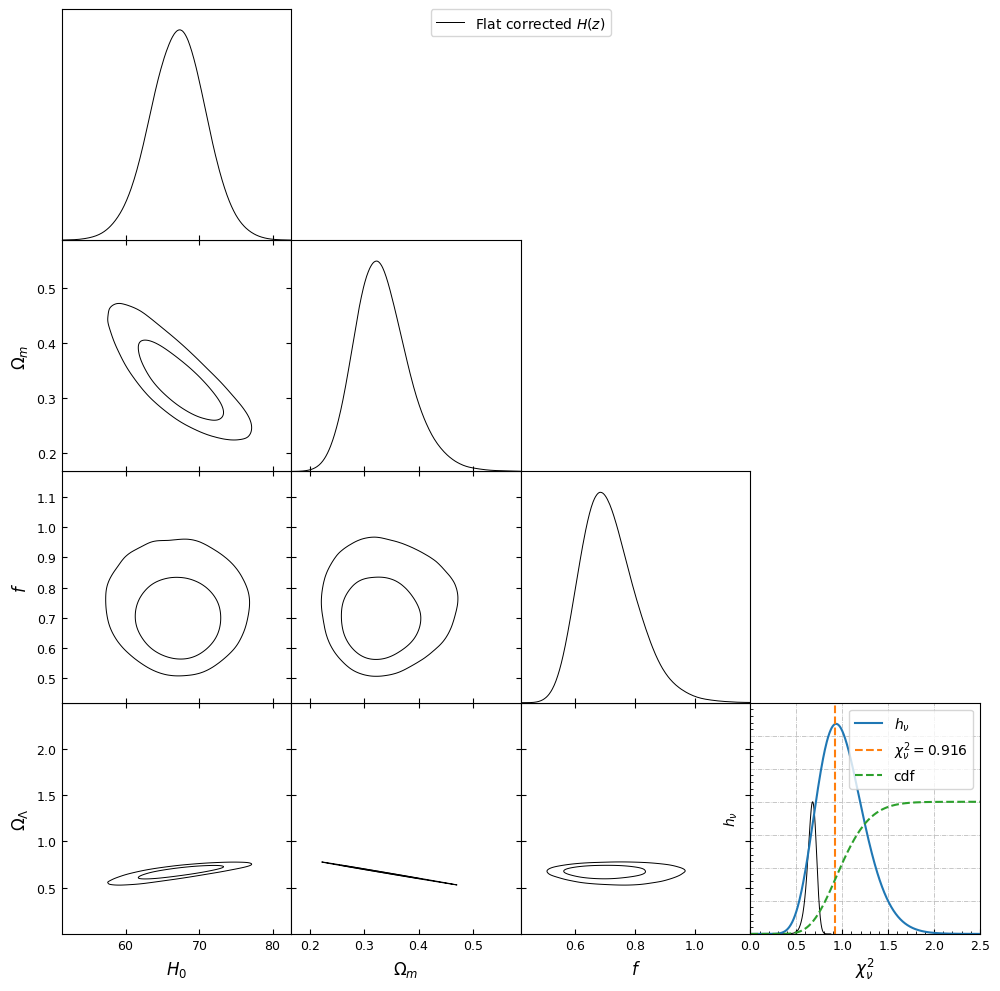

Probabilidade =  40.18990813530299
Chiv =  0.9159184102630259


In [55]:
chi2Ff=chi2Hz(free_par([67.10380,0.33287,0.72775], freef=True, flat=True))
plotChiDist(chi2Ff, len(par_HzFf), name='chi2FLCDM')
chivFfperc, errF = quad(chiDist, 0, chi2Ff/(ndata-len(par_HzFf)), args=(ndata-len(par_HzFf)))
print('Probabilidade = ', chivFfperc*100)
print('Chiv = ', chi2Ff/(ndata-len(par_HzFf)))

# Comparison between corrected and uncorrected Flat LCDM

In [59]:
g = plots.getSubplotPlotter(subplot_size=1.75)
g.triangle_plot([gsamplesHzFf, gsamplesHzF], [parnamesFf[0],parnamesFf[1],parnamesFf[2]], filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$'])
g.export('fig/gFlatcompUncCorrAll-triangle.pdf')

# Displacement in data no f

In [60]:
#Function to identify which model will be used
def free_parE(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f , e= theta
            return [h0, wm, wl, f, e]
        elif flat == True:
            h0, wm, f, e= theta
            return [h0, wm, 1-wm, f, e]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl, e = theta
            return [h0, wm, wl, 1, e]
        elif flat == True:
            h0, wm, e = theta
            return [h0, wm, 1-wm, 1, e]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2HzE(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[4] + (par[0]-par[4])*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = inv_cov/par[3]**2

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHzE(par):
    for i in range(len(par)):
        if not priorArrayE[i][0] < par[i] < priorArrayE[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHzE(par):
    chi2 = chi2HzE(par)
    return -0.5*chi2 - ndata*np.log(par[3])

#?
def lnprobHzE(theta, freef, flat):
    par = free_parE(theta, freef, flat)
    
    lp = lnpriorHzE(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHzE(par)

#Minimize chi2
def find_bestfitE(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

priorArrayE = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2], [-50,50]])

## Flat LCDM without factor f

In [61]:
par_HzE = [69.1929957609451,0.2480895086492853, 5.]
ndimE = len(par_HzE)
prefixE = 'LcdmHz32CovCorr'
parlabelsE = ['H_0','\Omega_m', '\epsilon']
parlabtexE = ['$H_0$','$\Omega_m$', '$\epsilon$']
parnamesE = ['H0','wm', 'e']

resultHzE = find_bestfit(lnprobHzE, par_HzE, parnamesE, freef=False, flat=True)
par_mlHzE = resultHzE['x']

Maximum likelihood result:
H0  =  67.9220083868301
wm  =  0.2585418562386453
e  =  -11.53060862031493
chi2min = 14.509563170806942
Total time: 0.033 seg


<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\O'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\e'
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:4: SyntaxWarning: invalid escape sequence '\O'
  parlabelsE = ['H_0','\Omega_m', '\epsilon']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:4: SyntaxWarning: invalid escape sequence '\e'
  parlabelsE = ['H_0','\Omega_m', '\epsilon']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:5: SyntaxWarning: invalid escape sequence '\O'
  parlabtexE = ['$H_0$','$\Omega_m$', '$\epsilon$']
C:\Users\nirk2\AppData\Local\Temp\ipykernel_15400\1451789100.py:5: SyntaxWarning: invalid escape sequence '\e'
  parlabtexE

In [62]:
samplerHzE = run_emcee(par_HzE, 100, lnprobHzE, False, True, 2.0, nstepHz)

 13%|█████████▊                                                                    | 631/5000 [00:04<00:30, 141.76it/s]


KeyboardInterrupt: 

In [ ]:
tauHzE = samplerHzE.get_autocorr_time()
print(tauHzE)

tauHzmaxE = np.amax(tauHzE)
r = nstepHz/tauHzmaxE
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

In [ ]:
samplesHzE = burninthin(samplerHzE, tauHzE)

In [ ]:
MC_result(samplesHzE, par_mlHzE, parnamesE)

In [ ]:
gsamplesHzE = MCSamples(samples=samplesHzE, names=parnamesE, labels=parlabelsE, ranges={'wm':(0, None)})
gsamplesHzE.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzE], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$'])
#g.export('fig/g'+prefix0+'All-triangle.pdf')

In [ ]:
samplesHzE, gsamplesHzE, parnamesE, ndim = insertDerived(samplesHzE, parnamesE, parlabelsE, 4, gsamplesHzE, 1 - gsamplesHzE.getParams().wm, 'wl', '\Omega_l')

In [ ]:
MC_result(samplesHzE, ndim, parnamesE)

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzE], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$'])
#g.export('fig/g'+prefixE+'All-triangle_Wk.pdf')

In [6]:
chi2E=chi2HzE(free_parE([70.60362,0.32969,3.18051], freef=False, flat=True))
plotChiDist(chi2E, len(par_HzE))
chivEperc, errF = quad(chiDist, 0, chi2E/(ndata-len(par_HzE)), args=(ndata-len(par_HzE)))
print('Probabilidade = ', chivEperc*100)
print('Chiv = ', chi2E/(ndata-len(par_HzE)))

NameError: name 'chi2HzE' is not defined

## Flat LCDM with factor f

In [ ]:
par_HzEf = [69.1929957609451,0.2480895086492853,.9, 5.]
ndimEf = len(par_HzEf)
prefixEf = 'LcdmHz32CovCorr'
parlabelsEf = ['H_0','\Omega_m', 'f', '\epsilon']
parlabtexEf = ['$H_0$','$\Omega_m$', 'f', '$\epsilon$']
parnamesEf = ['H0','wm', 'f','e']

resultHzEf = find_bestfit(lnprobHzE, par_HzEf, parnamesEf, freef=True, flat=True)
par_mlHzEf = resultHzEf['x']

In [ ]:
samplerHzEf = run_emcee(par_HzEf, 100, lnprobHzE, True, True, 2.0, nstepHz)

In [ ]:
tauHzEf = samplerHzEf.get_autocorr_time()
print(tauHzEf)

tauHzmaxEf = np.amax(tauHzEf)
r = nstepHz/tauHzmaxEf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

In [ ]:
samplesHzEf = burninthin(samplerHzEf, tauHzEf)

In [ ]:
MC_result(samplesHzEf, par_mlHzEf, parnamesEf)

In [ ]:
gsamplesHzEf = MCSamples(samples=samplesHzEf, names=parnamesEf, labels=parlabelsEf, ranges={'wm':(0, None)})
gsamplesHzEf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

In [ ]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzEf], filled=False, legend_labels=['Flat $\Lambda$CDM with $\epsilon$ and f'])
#g.export('fig/g'+prefix0+'All-triangle.pdf')

In [ ]:
chi2Ef = chi2HzE(free_parE([71.28834, 0.32342, 0.72746, 3.75071], freef=True, flat=True))
plotChiDist(chi2Ef, len(par_HzEf))
chivEfperc, errF = quad(chiDist, 0, chi2Ef/(ndata-len(par_HzEf)), args=(ndata-len(par_HzEf)))
print('Probabilidade = ', chivEperc*100)
print('Chiv = ', chi2Ef/(ndata-len(par_HzEf)))

## OLCDM without factor f

In [ ]:
par_HzCE = [69.1929957609451,0.2480895086492853, 0.6862431649000225, 5.]
ndimCE = len(par_HzCE)
prefixCE = 'LcdmHz32CovCorr'
parlabelsCE = ['H_0','\Omega_m', '\Omega_l', '\epsilon']
parlabtexCE = ['$H_0$','$\Omega_m$', '$\Omega _{\Lambda}', '$\epsilon$']
parnamesCE = ['H0','wm', 'wl', 'e']

resultHzCE = find_bestfitE(lnprobHzE, par_HzCE, parnamesCE, freef=False, flat=False)
par_mlHzCE = resultHzCE['x']

## OLCDM with factor f

In [ ]:
par_HzCEf = [69.1929957609451,0.2480895086492853, 0.6862431649000225, .9, 5.]
ndimCEf = len(par_HzCEf)
prefixCEf = 'LcdmHz32CovCorr'
parlabelsCEf = ['H_0','\Omega_m', '\Omega_l', 'f' '\epsilon']
parlabtexCEf = ['$H_0$','$\Omega_m$', '$\Omega _{\Lambda}', '$\epsilon$', '$\epsilon$']
parnamesCEf = ['H0','wm', 'wl', 'f', 'e']

resultHzCEf = find_bestfitE(lnprobHzE, par_HzCEf, parnamesCEf, freef=True, flat=False)
par_mlHzCEf = resultHzCEf['x']